# Lab 3: Temporal Difference Learning


## From Unsupervised to Supervised Learning

Unsupervised learning allows a model to discover structure present in the environment.  This is a powerful way to build up a *neutral* representation of the world.  But a represntation generated by unsupervised learning does not have any valence (positive or negative value) -- it does not tell you what things in the world are good or bad for you.  Such a representation might help you infer what to expect, but it does not tell you what to do.  We need a way to learn how to behave -- how to make better decisions and act to optimize rewards (increase positive outcomes, decrease negative outcomes).  

Attaching value to things in the world, and making decisions that can arrive at these values introduces a key opportunity for training.  Supervised learning introduces the concepts of correct and incorrect, better and worse.  In supervised learning the ends alter the means; the valenced outcome can reach back to change the processing that lead up to that outcome -- and when this learning works, it leads to better future decisions and outcomes.                         


## Predictions are Hard

At first pass, the only way to make accurate predictions is to travel backward in time.  When you first receive a chocolate icecream cone your entire life lead up to this momentous occasion -- what part of your life should be credited as its predictor?  Less extravagantly, even the few minutes before getting the icecream your natural environment contained an incredible amount of information and your brain cycled through a vast number of different states.  What feature of the environment might guide you to future icecream cones?  Which stimuli and brain states were the predictors?  Figuring this out is known as the credit assignment problem; it's an extremely hard problem to solve and we'll return to it repeatedly this semester.

In order to survive, animals need to pursue rewarding things like food and avoid harmful things like getting attacked by other animals.  Any ability to predict reward or punishment is generally helpful.  Prediction requires associating a reward or punishment with things that consistently precede it.  If seeing over-ripe fruit on the ground is correlated with later finding ripe fruit above in the tree, the neutral stimulus of rotting fruit on the ground should teach you to look up for a rewarding piece of ripe fruit.  (In behaviorist jargon, the rotting fruit on the ground begins as a neutral stimulus, looking up begins as an unconditioned response and the fruit in the tree is an unconditioned stimulus -- after learning, the rotting fruit is a conditioned stimulus and looking up is a conditioned response.)  If an animal growling is correlated with that animal then attacking, hearing growling should make you prepare for an attack.  

How might animals learn to accurately predict rewards?  Neural activity associated with a reward could gradually become associated with stimuli that precede the reward.  Remember that with Hebbian Learning "neurons that fire together, wire together" and this can operate over both **spatial & temporal proximity**.  Temporal proximity can potentially give us prediction.  If a small red circle always appears right before a large chocolate icecream cone, the reward signal produced by the icecream cone could eventually become correlated with the small red circle.   
        

## Temporal Difference Learning

Temporal difference learning is a method that allows predictions to travel backward in time.  Okay, not exactly, but kind of -- **it allows predictions to propogate backward in our representation of time.**  

We start with a temporal sequence of stimuli: A->B->C->D.  Let's call stimuli distributed over time *events*.  Hebbian learning allows us to build up a neutral representation of this temporal sequence of events.  Now at timepoint D you get a reward.  We want to associate the earliest event that reliably predicts this reward with the reward.  Temporal difference learning is a way to transfer the prediction backward from D to C, from C to B, and ultimately from B to A.  

The key to understanding temporal difference learning is to stop thinking about time as time, and start thinking about time as a linear object.  The line is a sequence of stimulus events and waiting (between events).  If you imagine time flows from left (past) to right (future), we want information about rewards to flow from right (future) to left (past) to create predictions.  


### Temporal Difference Learning from Prediction Errors 
In this lab, we will be recreating the model of mesolimbic dopamine cell activity during monkey conditioning proposed by [Montague, Dayan, and Sejnowski in their 1996 paper](http://www.jneurosci.org/content/jneuro/16/5/1936.full.pdf). This model compares temporal difference learning from prediction errors to physiological data. We'll use this model to replicate Figure 5 from the paper.


We'll start by importing Numpy, Matplotlib, and PsyNeuLink, and the 3D toolkit from Matplotlib.


**Note**: *Some of the PsyNeuLink syntax in this notebook is a little different than the current syntax that you've become familiar with over the previous two labs.  PNL is under active developmen and the TD learning exercises that work so well in this notebook are not ironed out in the current branch of PNL, so we're installing an older version of PNL in the cell below. Your lab instructor will help you navigate these minor differences.  A couple things to be aware of with this older syntax is that Composition (new syntax) = System (old syntax); an intermediate structure that linked together mechanisms to support learning was called a Process (old syntax).*

In [1]:
# uncomment to install psyneulink
!pip install psyneulink

In [2]:
import numpy as np
import psyneulink as pnl

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns 

%autosave 5
%matplotlib inline

print(pnl.__version__)

np.random.seed(0)
sns.set(style='white', context='talk', palette="colorblind")

Autosaving every 5 seconds
0.8.6.0


Figure 5A is a "plot of ∂(t) over time for three trials during training (1, 30, and 50)", where $∂(t) = r(t) + w(t)x(t) - w(t - 1)x(t - 1)$ is the difference between the stimulus value and the reward.

For this experiment, the stimulus (a light) starts at timestep 41 and continues for the remainder of the trial, and the reward is delivered at timestep 54, so we'll create variables to represent that.

Next, we'll create the arrays that represent the samples and targets. The sample values in this experiment stay the same across all trials, but the targets do not; every 15 trials, the reward was withheld.

In [3]:
def build_stimulus(n_trials, n_time_steps, no_reward_trials, stimulus_onset=41, reward_delivery=54):

    samples = []
    targets = []
    for trial in range(n_trials):
        target = [0.] * n_time_steps
        target[reward_delivery] = 1.
        if trial in no_reward_trials:
            target[reward_delivery] = 0.
        targets.append(target)

        sample = [0.] * n_time_steps
        for i in range(stimulus_onset, n_time_steps):
            sample[i] = 1.
        samples.append(sample)

    return np.array(samples), np.array(targets)

In [4]:
n_time_steps = 60
n_trials = 120
no_reward_trials = {14, 29, 44, 59, 74, 89}
samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)

The following 3 cells are included simply to view (inspect) elements that were created in the previous cell.  Whenever you aren't certain what some line of code is doing, try creating a new cell and executing parts of the code that are not yet clear.   

In [5]:
"""
inspect: 

samples represents the absence [0] and presence [1] 
of a stimulus over 120 units of time.

targets represents the absence [0] and presence [1] 
of a reward over 120 units of time. 
"""

trial_id = 0 
print('samples:\n', samples[trial_id,])
print('targets:\n', targets[trial_id,])

samples:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
targets:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


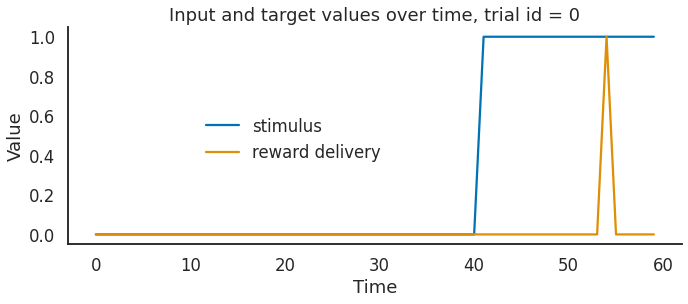

In [6]:
trial_id = 0

f, ax = plt.subplots(1, 1, figsize=(11,4))
ax.plot(samples[trial_id,], label='stimulus')
ax.plot(targets[trial_id,], label='reward delivery')

ax.set_title(f'Input and target values over time, trial id = {trial_id}')
ax.set_ylabel('Value')
ax.set_xlabel('Time')
f.legend(bbox_to_anchor=(.5,.7),frameon=False)
sns.despine()

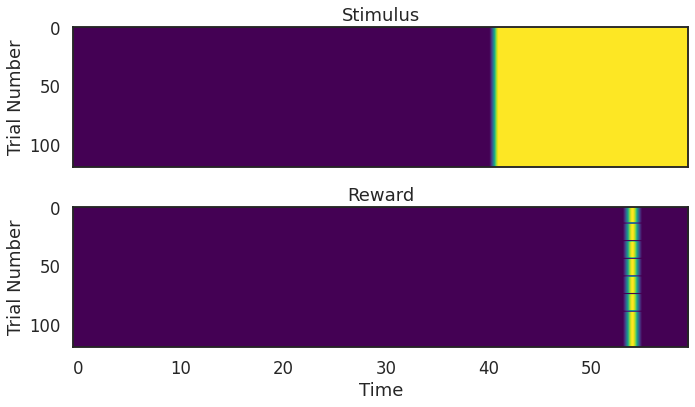

In [7]:
f, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

axes[0].imshow(samples, cmap='viridis', aspect='auto')
axes[0].set_ylabel('Trial Number')
axes[0].set_title('Stimulus')

axes[1].imshow(targets, cmap='viridis', aspect='auto')
axes[1].set_ylabel('Trial Number')
axes[1].set_title('Reward')
axes[1].set_xlabel('Time')
f.tight_layout()

In [8]:
# inspect: We have 120 trials, each with 120 units of time, 
print('targets shape: ', np.shape(targets))

targets shape:  (120, 60)


Now we'll set up the input values for the samples and the targets. We'll put the `samples` and `targets` variables in dictionaries assigned to the `sample` and `action_selection` mechanisms, respectively. Then we'll create the System in which the Process will run.

In [9]:
def get_model(composition_name='TD', learning_rate=.3):
    """get a model, described in Montague, Dayan, and Sejnowski (1996)

    Parameters
    ----------
    composition_name : str
        the name of the composition
    learning_rate : float
        learning rate, default to .3

    Returns
    -------
    pnl.composition, list
        the model
    """

    # Create Processing Components
    sample_mechanism = pnl.TransferMechanism(default_variable=np.zeros(60),
                                              name=pnl.SAMPLE)

    action_selection = pnl.TransferMechanism(default_variable=np.zeros(60),
                                              function=pnl.Linear(slope=1.0,
                                                                  intercept=0.01),
                                              name='Action Selection')

    sample_to_action_selection = pnl.MappingProjection(sender=sample_mechanism,
                                                        receiver=action_selection,
                                                        matrix=np.zeros((60, 60)))
    # Create Composition
    composition_name = 'TD_Learning_Figure_5A'
    comp = pnl.Composition(name=composition_name)

    # Add Processing Components to the Composition
    pathway = [sample_mechanism, sample_to_action_selection, action_selection]

    # Add Learning Components to the Composition
    learning_related_components = comp.add_td_learning_pathway(pathway, learning_rate).learning_components

    # Unpack Relevant Learning Components
    prediction_error_mechanism = learning_related_components[pnl.OBJECTIVE_MECHANISM]
    target_mechanism = learning_related_components[pnl.TARGET_MECHANISM]

    # Create Log
    prediction_error_mechanism.log.set_log_conditions(pnl.VALUE)

    nodes = [sample_mechanism, prediction_error_mechanism, target_mechanism]


    return comp, nodes

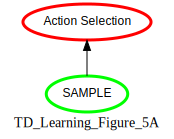

In [10]:
comp, nodes = get_model()
[sample_mechanism, prediction_error_mechanism, target_mechanism] = nodes
comp.show_graph(output_fmt='jupyter')

In [11]:
samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)

input_dict = {
    sample_mechanism: samples,
    target_mechanism: targets
}

comp.learn(inputs=input_dict)

[[array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01])],
 [array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.31, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01])],
 [array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0

Now we can create the plot

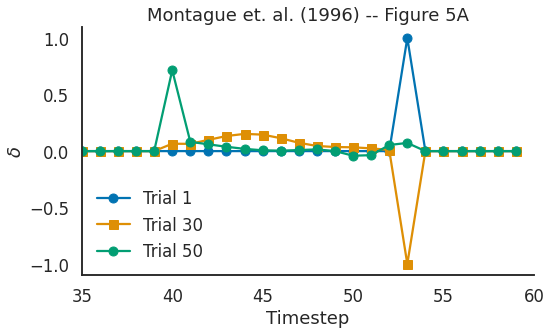

In [12]:
# Get Delta Values from Log
delta_vals = prediction_error_mechanism.log.nparray_dictionary()[
    comp.name][pnl.VALUE]

# Plot Delta Values form trials 1, 30, and 50
t_start = 35
fig = plt.figure(figsize=(8, 5))
plt.plot(delta_vals[0][0], "-o", label="Trial 1")
plt.plot(delta_vals[29][0], "-s", label="Trial 30")
plt.plot(delta_vals[49][0], "-o", label="Trial 50")
plt.title("Montague et. al. (1996) -- Figure 5A")
plt.xlabel("Timestep")
plt.ylabel(r"$\delta$")
plt.legend(frameon=False)
plt.xlim([t_start, n_time_steps])
plt.xticks()
fig.tight_layout()
sns.despine()

### Lab Exercise 1a
Write a detailed caption for the figure created above.  You can refer to the original paper, but the caption you write must be your own words.  Your caption should both describe and interpret the information depicted, such that the figure plus your caption can "stand alone" and make sense to someone who has not read the paper.      

### Lab Exercise 1b
Scroll back up to the cell that executes the model and quickly scan over all the delta values on each trial.  Note that trial 0 in the printed output is depicted as trial 1 in the graph above (because Python indexes starting at 0).  At what point has the prediction migrated to the onset of the stimulus with a value above 0.5?    



## 3D Plot, Figure 5B

Now we'll create a 3D plot showing the entire time course of the experiment. According to the paper, training began at trial 10, so we'll edit the targets array to match and run the system again.  

(Again, it will take a minute or two to complete running.)

In [13]:
comp, nodes = get_model()
[sample_mechanism, prediction_error_mechanism, target_mechanism] = nodes

# Create Stimulus Dictionary
n_time_steps = 60
n_trials = 120
no_reward_trials = {
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 29, 44, 59, 74, 89, 104, 119
}
samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)


input_dict = {
    sample_mechanism: samples,
    target_mechanism: targets
}

comp.learn(inputs=input_dict)

[[array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01])],
 [array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01])],
 [array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
         0.01, 0

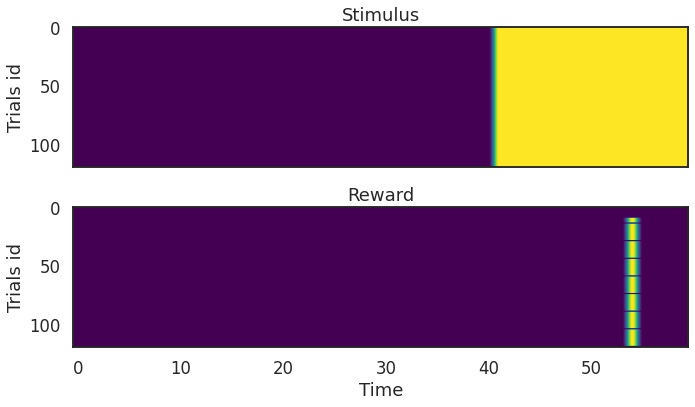

In [14]:
f, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

axes[0].imshow(samples, cmap='viridis', aspect='auto')
axes[0].set_ylabel('Trials id')
axes[0].set_title('Stimulus')

axes[1].imshow(targets, cmap='viridis', aspect='auto')
axes[1].set_ylabel('Trials id')
axes[1].set_title('Reward')
axes[1].set_xlabel('Time')
f.tight_layout()

Text(0.5, 0.92, 'Montague et. al. (1996) -- Figure 5B')

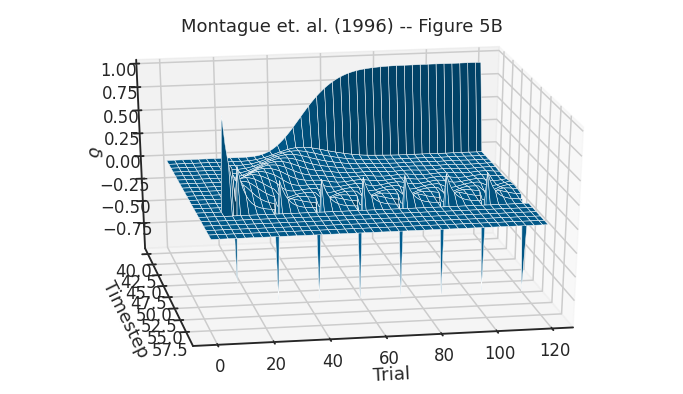

In [15]:
# Get Delta Values from Log
delta_vals = np.squeeze(
    prediction_error_mechanism.log.nparray_dictionary()[comp.name][pnl.VALUE]
)

t_start = 40
x_vals, y_vals = np.meshgrid(
    np.arange(n_trials), np.arange(t_start, n_time_steps))
d_vals = delta_vals[:, t_start:n_time_steps].T

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(25, 80)
ax.plot_surface(x_vals, y_vals, d_vals, linewidth=.5)
ax.invert_xaxis()
ax.set_xlabel("\nTrial")
ax.set_ylabel("\nTimestep")
ax.set_zlabel('\n'+r"$\delta$")
ax.set_title("Montague et. al. (1996) -- Figure 5B")

This 3D figure contains a lot of information.  The z-axis is timesteps within a trial (time within trials is moving from the back "wall" toward the front of the graph).  Although we had 120 time steps in each trial, this figure is zoomed in on the action; between the onset of the stimulus at timestep 41 and the delivery of reward at timestep 54.  To first approximation the y-axis displays predictions and prediction errors -- positive values are predictions, and negative values are prediction errors (i.e. when a predicted reward was absent).  The x-axis displays all 120 trials of the experiment, progressing from left to right.  There are some prominent features in the graph.  On the back wall you can see the gradual positive build up (it looks a bit like a wave) of reward prediction accumulating at the onset of the stimulus (timestep 41, when the light turns on) -- the model is learning what it is supposed to!  Near the front left you can see predictions starting after the first trial with a reward, and you can see the negative spikes of prediction error on all the trials where reward was withheld.       

## Figure 5C

Finally, we'll recreate Figure 5C which demonstrates "extinction of response to the sensory cue." After trial 70, we'll stop delivering reward so the system unlearns the response to the sensory cue. In order to show the full effect, this time we will run 150 trials.

In [16]:
comp, nodes = get_model()
[sample_mechanism, prediction_error_mechanism, target_mechanism] = nodes

# Create Stimulus Dictionary
n_trials = 150
reward_removal_onset = 70
no_reward_trials = np.arange(reward_removal_onset, n_trials)
samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)

# Run Composition
input_dict = {sample_mechanism: samples, target_mechanism: targets}
comp.learn(inputs=input_dict);

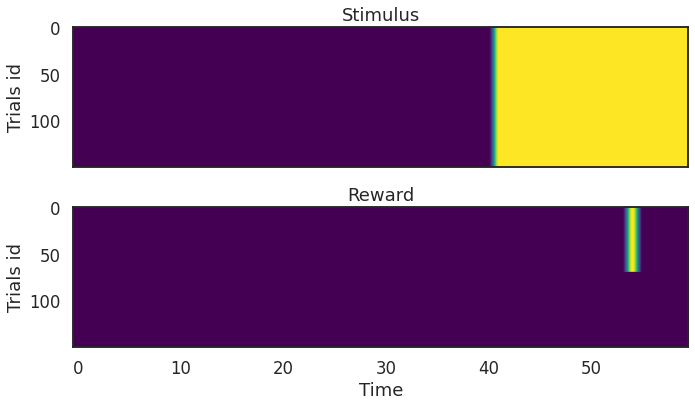

In [17]:
f, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

axes[0].imshow(samples, cmap='viridis', aspect='auto')
axes[0].set_ylabel('Trials id')
axes[0].set_title('Stimulus')

axes[1].imshow(targets, cmap='viridis', aspect='auto')
axes[1].set_ylabel('Trials id')
axes[1].set_title('Reward')
axes[1].set_xlabel('Time')
f.tight_layout()

Text(0.5, 0.92, 'Montague et. al. (1996) -- Figure 5C')

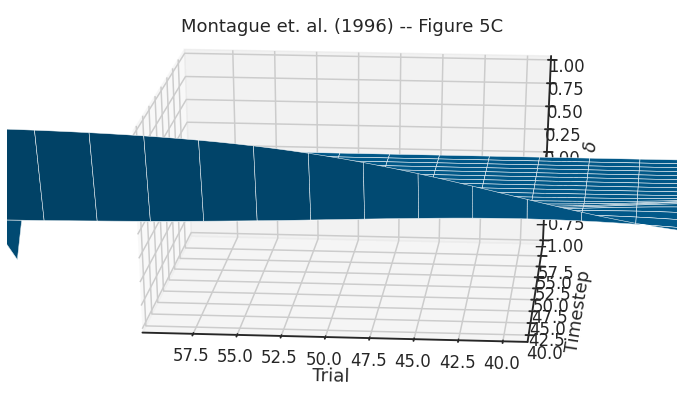

In [18]:
# Get Delta Values from Log
delta_vals = np.squeeze(
    prediction_error_mechanism.log.nparray_dictionary()[comp.name][pnl.VALUE]
)

t_start = 40
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
x_vals, y_vals = np.meshgrid(
    np.arange(n_trials), np.arange(t_start, n_time_steps))
d_vals = delta_vals[:, t_start:n_time_steps].T
ax.plot_surface(x_vals, y_vals, d_vals, linewidth=.5)
ax.view_init(25, 275)
ax.invert_yaxis()
ax.set_xlabel("\nTrial")
ax.set_ylabel("\nTimestep")
ax.set_zlabel('\n'+r"$\delta$")
ax.set_title("Montague et. al. (1996) -- Figure 5C")

# Lab Exercises

## 1.  Your TD Model
Create a new TD learning model with 60 trials and 40 timesteps. In every trial the stimulus should appear at timestep 10 and persist through the rest of the trial.  Reward appears at timestep 25 in all trials except trials 15, 25, 35, 45.  Run the model and create a figures comparable to 5A, plotting trials 1, 25, & 55.  Describe any noteworthy learning differences between the results in your figure and the original. 


Tips: Reuse the code from the model that produces figure 5A.  Create two variables, numTrials = 60, and numSteps = 40, then replace the 120's throughout the code with the appropriate variable names.  When you make the figure, change the title to "(Your Last Name) TD Learning Model (2018)" and change other labels to be accurate.    


## 2.  Learning Rate
Try modifying the learning rate in your TD model to see what happens.  Create three 5A style figures with three different learning rates: 0.1, 0.3, and 0.7.  (0.3 is the learning rate in the original model).  Update your figure titles to reflect the learning rate, and save your figures to include in your homework notebook.  Write a paragraph or two describing interesting features when comparing the different learning rates.  


## 3.  Reward Variability  
Remove the reward on every third trial and run your model again with a learning rate of 0.3.  Create a 3D figure like 5B, and include it in your homework notebook.  Describe these results and how you interpret them.       


## 4. Stimulus Variability
Your TD learning model gradually learns to associate the earliest stimulus that reliably predicts the reward.  Try adding a gap in the persistence of the stimulus at time step 15.  Here's some code to help     


```{python}
stimulus_onset = 10
stimulus_gap = 15
reward_delivery = 25


samples = np.zeros(numSteps)
samples[stimulus_onset:] = 1 # this sets all indices from stimulus_onset to the end to 1
samples[stimulus_gap] = 0
samples = np.tile(samples, (numTrials, 1)) # this creates a 2D array that replicates samples for all trials
```

Now the stimulus will onset at timestep 10, disappear at timestep 15, then reappear at timestep 16 and remain present for the rest of each trial.  

Run the model, describe what happens, and explain why. 


## 5. B.U.I.L.D.
